# Style Transfer

Author: Rafael Godoy

LinkedIn: https://www.linkedin.com/in/Rafael-Godoy-ML-Eng

Github: https://github.com/RafaelSilvaGodoy

In this notebook it will be developed a NN for **Style Transfer**. The task consists in using two pictures, one as content and the other as style and then combine both images to generate the "mixture" of them.

Some applications of style transfer are:
- Autonomous cars to change the real-life image to one closer to the simulator`s used; 
- Image filters;

This notebook was prepared to run using Google Colab due to the GPU.

Most of code used was made by: https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from PIL import Image
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models, losses, layers, backend as K

In [ ]:
# Set your content and style images paths 

content_path = "/content/drive/MyDrive/Colab Notebooks/transferencia de estilo/IMG_5651.jpg"
style_path = "/content/drive/MyDrive/Colab Notebooks/transferencia de estilo/the_starry_night-wallpaper-1920x1080.jpg"

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  img = kp_image.img_to_array(img)

  img = np.expand_dims(img, axis=0)
  return img

def imshow(img, title=None):
  out = np.squeeze(img, axis=0)
  out = out.astype("uint8")
  plt.imshow(out)
  if title is not None:
    plt.title(title)
    plt.imshow(out)

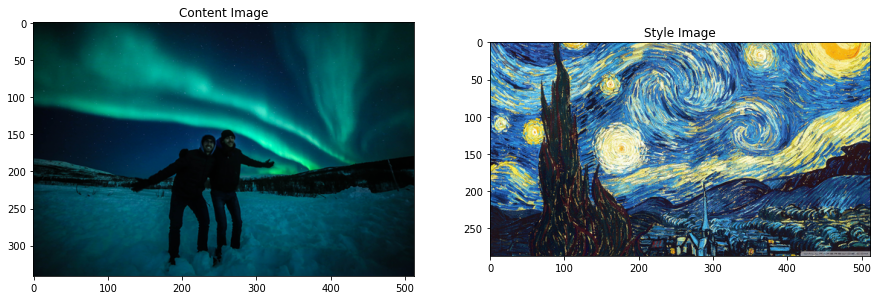

In [ ]:
# Shows the respective Content Image and Style Image

plt.figure(figsize=(15,15))

content = load_img(content_path).astype("uint8")
style = load_img(style_path).astype("uint8")

plt.subplot(1,2,1)
imshow(content,"Content Image")

plt.subplot(1,2,2)
imshow(style,"Style Image")

In [ ]:
# Loads the VGG19 NN.
rna = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
rna.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
#from tensorflow.keras.applications import vgg19

def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [ ]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x,0)

  assert len(x.shape)==3, ("Images should have dimentions [1, height, width, channel]")

  if len(x.shape)!=3:
    raise ValueError("Invalid input")

  x[:,:,0] += 103.939
  x[:,:,1] += 116.779
  x[:,:,2] += 123.68
  x = x[:,:,::-1]

  x = np.clip(x, 0, 255).astype("uint8")
  return x

In [ ]:
content_layers = ["block5_conv2"]

style_layers = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def get_model():
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet")
  vgg.trainable = False

  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in  content_layers]
  model_outputs = style_outputs + content_outputs

  return models.Model(vgg.input, model_outputs)

In [ ]:
model = get_model()

style_image = load_and_process_img(style_path)

style_outputs = model(style_image)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("shape:", output.numpy().shape)
  print("min:", output.numpy().min())
  print("max:", output.numpy().max())
  print("mean:", output.numpy().mean())
  print("")

In [ ]:
def get_content_loss(base_content, target):
  JC = tf.reduce_mean(tf.square(base_content - target))/2
  return JC

In [ ]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  A = tf.reshape(input_tensor, [-1, channels])
  gram = tf.matmul(A,A, transpose_a=True)
  return gram

In [ ]:
def get_style_loss(base_style, gram_target):

  height, width, channels = base_style.get_shape().as_list()

  gram_style = gram_matrix(base_style)

  JS = tf.reduce_mean(tf.square(gram_style-gram_target))/ (4.* (channels*width*height)**2)

  return JS

In [ ]:
def get_feature_representations(model, content_path, style_path):

  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)

  style_outputs = model(style_image)
  content_outputs = model(content_image)

  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[:num_content_layers]]

  return style_features, content_features

In [ ]:
# Loss function to train the NN

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

  style_weight, content_weight = loss_weights

  model_outputs = model(init_image)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[:num_content_layers]

  style_score = 0
  content_score = 0

  weight_per_style_layer = 1.0/float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

  weight_per_content_layer = 1.0/float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content)

  style_score *= style_weight
  content_score *= content_weight

  loss = style_score + content_score

  return loss, style_score, content_score     

In [ ]:
def compute_grads(cfg):
  with tf.GradientTape() as G:
    all_loss = compute_loss(**cfg)

  total_loss = all_loss[0]

  return G.gradient(total_loss, cfg["init_image"]), all_loss

In [ ]:
import IPython.display

def run_style_transfer(content_path, style_path, num_iterations=1, content_weight=100, style_weight=100):

  model = get_model()
  for layer in model.layers:
    layer.trainable = False

  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)

  opt = tf.optimizers.Adam(learning_rate=5)

  iter_count = 1

  best_loss, best_img = float("inf"), None

  loss_weights = (style_weight, content_weight)
  cfg = {"model":model, "loss_weights":loss_weights, "init_image":init_image, "gram_style_features":gram_style_features, "content_features":content_features}

  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()


  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means

  imgs = []
  history = np.zeros(num_iterations)

  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads,init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time()

    if loss < best_loss:
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval ==0:
      start_time = time.time()

      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print("Iteration: ", i)

    history[i] = loss

  print("total time: ", time.time()- global_start)
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))

  for i,img in enumerate(imgs):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

  return best_img, best_loss, history

In [ ]:
def show_result(best_img, content_path, style_path, show_large=True):

  plt.figure(figsize=(20,20))
  content = load_img(content_path)
  style = load_img(style_path)

  plt.subplot(1,2,1)
  imshow(content, "Content Image")

  plt.subplot(1,2,2)
  imshow(style, "Style Image")

  if show_large:
    plt.figure(figsize=(15,15))
    plt.imshow(best_img)
    plt.title("output Image")
    plt.show()


In [ ]:
# Sets which layers will be used, you can choose as you wish

content_layers = ["block5_conv3"]

style_layers = ["block1_conv2","block2_conv2","block3_conv2","block4_conv2","block5_conv2"]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

custo:  tf.Tensor(48692.68, shape=(), dtype=float32)


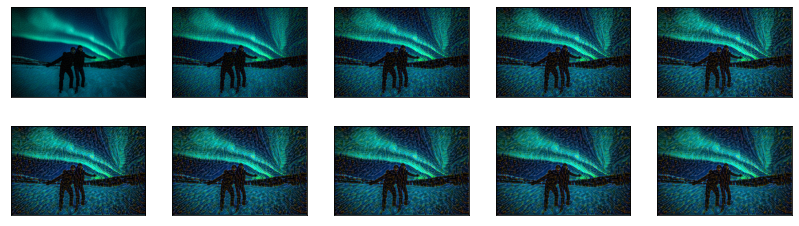

In [ ]:
# The num_iterations, content_weight, style_weight and the layers are variables that influence diractly into the output image
# The sequency of pictures shows the style being tranferred

best_4, best_loss_4, history4 = run_style_transfer(content_path, style_path, num_iterations=50, content_weight=100, style_weight=20)
print("loss: ", best_loss_4)

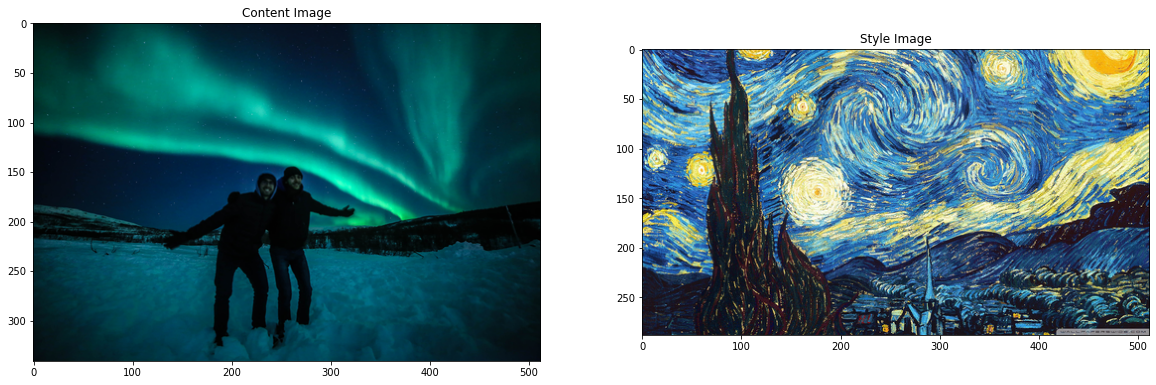

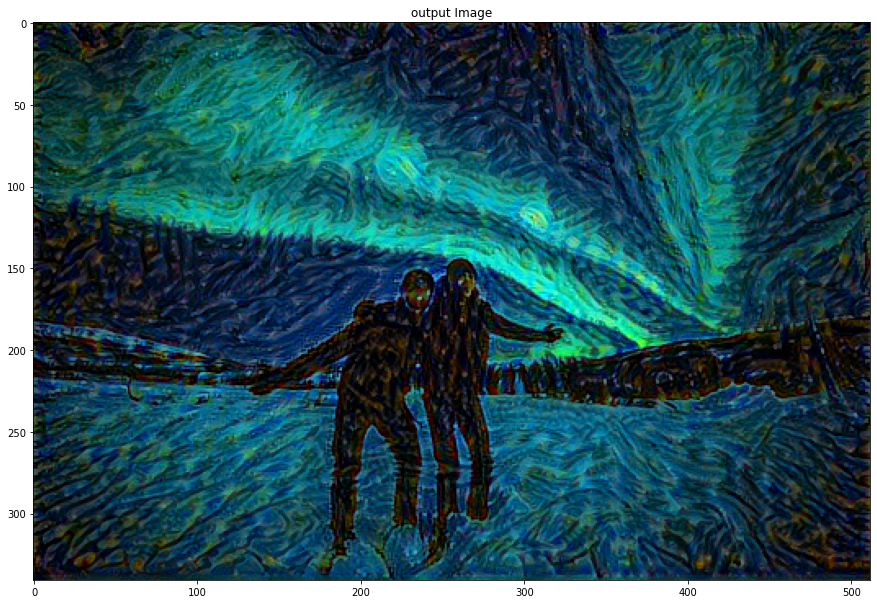

In [ ]:
# The comparison between the content image (myself), with the style image (The Starry Night) and the output
show_result(best_4, content_path, style_path)

custo:  tf.Tensor(245265.84, shape=(), dtype=float32)


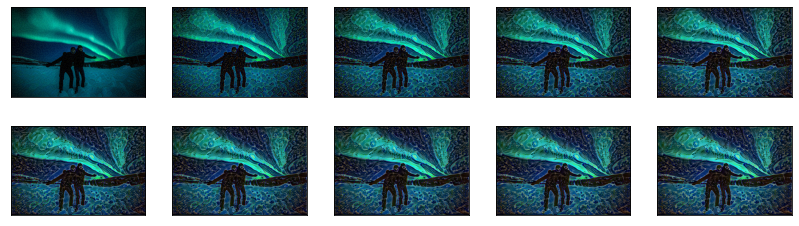

In [ ]:
# Testing with a different style image

best_6, best_loss_6, history6 = run_style_transfer(content_path, "/content/drive/MyDrive/Colab Notebooks/transferencia de estilo/onda.jpg", num_iterations=100, content_weight=100, style_weight=100)
print("loss: ", best_loss_6)

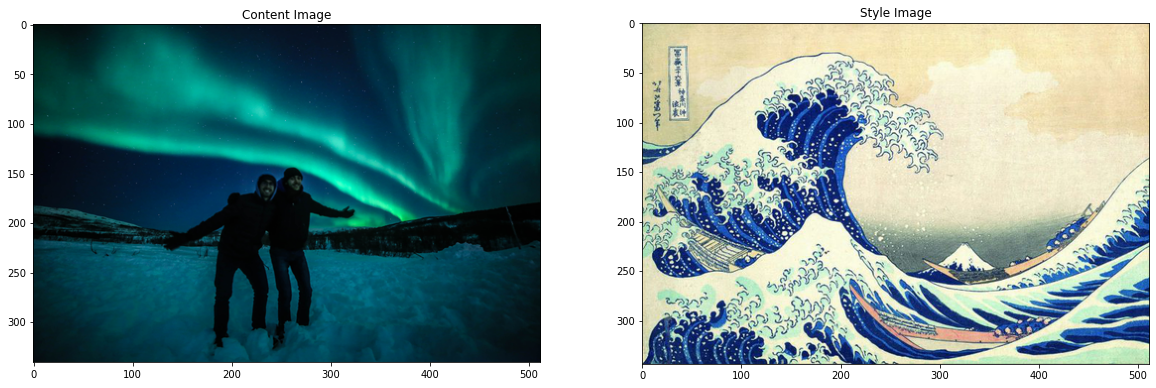

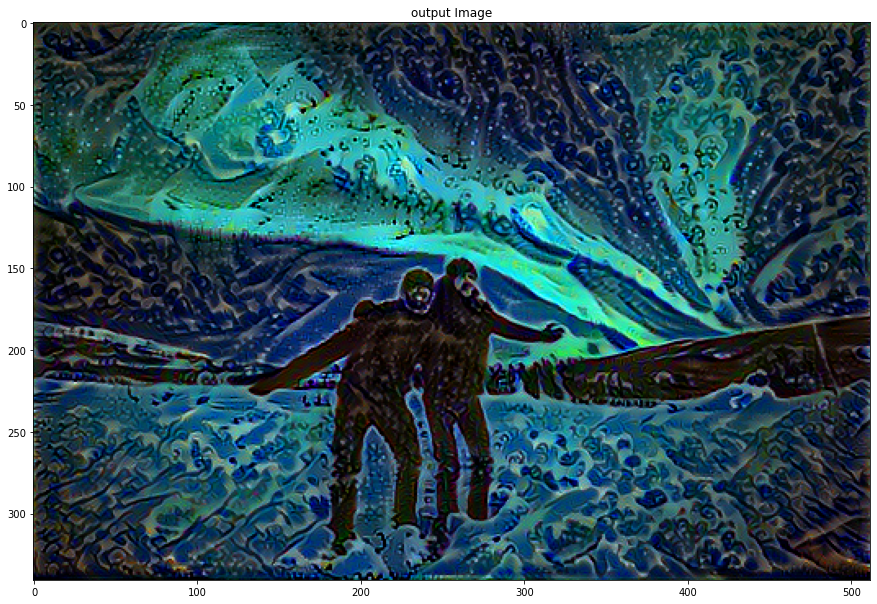

In [ ]:
# The comparison between the content image (myself), with the style image (The Great Wave off Kanagawa) and the output
show_result(best_6, content_path, "/content/drive/MyDrive/Colab Notebooks/transferencia de estilo/onda.jpg")